# General Adversarial Nets
## An introduction and Overview
### By Rohit Goswami (rgoswami@iitk.ac.in)

## Setup
This is not for N00bs. `python` is just a pain with dependencies.
### Welcome to the Matrix
A virtual python is necessary to keep from python universes colliding and imploding. As per my best practices guide-lines, we will use `direnv`, `pyenv` and `poetry`, along with `virtualenvwrapper`. Do take this as an exercise in Google-fu.
So:
```bash
export verPy="3.7.0"
export cuteName="mySanity"
pyenv install $verPy
source /usr/bin/virtualenvwrapper_lazy.sh
mkvirtualenv -p $HOME/.pyenv/versions/$verPy/python $cuteName
echo "layout virtualenvwrapper $cuteName" >> .envrc
direnv allow
```

By the end of this you have a shiny new mini-python universe.

### Poetry
Much like real poetry, this is expressive and deep, but shorter than mucking around with `conda`.
```bash
pip install poetry
poetry init
```

### GUI or IUG
So by now we are ready for graphical user interfaces or interfacing with ugly geeks. Let us use `jupyter-notebooks` because somehow there's a lot of free compute for them. This section is inspired by [this blog](https://anbasile.github.io/programming/2017/06/25/jupyter-venv/)
```bash
poetry add ipython seaborn matplotlib pandas numpy scipy sklearn ipykernel
poetry run jupyter notebook
```
The astute reader will notice that we have magically also added the necessary packages for the rest of this notebook.

In [10]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import tensorflow as tf
from scipy.stats import norm
# I don't care about your dread warnings of the future
import warnings
warnings.filterwarnings('ignore')

## Example 1: The MNIST GAN
This is a simple example of a `keras` workflow which ran for about half an hour on my quad core i7 machine.
The GIF is fun, but the main thing to see is the initial and final images. This section is largely from [this repository](https://github.com/eriklindernoren/Keras-GAN/). 
![In the beginning](images/mnistGAN/0.png)
![After 29800 epochs](images/mnistGAN/29800.png)
The accuracy after $29999$ epochs was $71.88%$ which is not all that great but you can see that it is rather clear overall. The loss of the discriminator was $0.556476$ and the loss for the generator was $1.002800$
![An animated GIF of the run](images/mnistGAN/animation.gif)
Honestly the code is pretty self-explanatory and doesn't really shed much light on the theory. Plus it takes a while. Anyway, it is here:
```python
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=30000, batch_size=32, sample_interval=200)

```

### Rules of Thumb
So these are basically tested personally and from [this post](https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0). `G=Generator, D=Discriminator`

| **Problem**                                                      | **Possible Fix**                                                                                                                                         |
|--------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------|
| Noisy images (G)                                             | Set low dropout values $\in(0.3, 0.6)$ on G and D for improved images                                                                                 |
| D loss converges rapidly to zero, preventing G from learning | Do not pre-train D and increase the learning rate relative to the Adversarial model learning rate OR/AND Use a different training noise sample for G |
| G is noisy (again)                                           | Apply in the right sequence, Activation->batch normalization->dropout                                                                                |
| Hyperparameter selection                                     | Trial and error, maybe adjust in steps of 500 or 1000 OVAT                                                                                           |

## Example 2: Toying with Gaussians
This is a sample problem best described [here](https://blog.evjang.com/2016/06/generative-adversarial-nets-in.html).
### The Target
Consider a simple Gaussian we will try to emulate. We will call this the target distribution or, $p_{data}$.

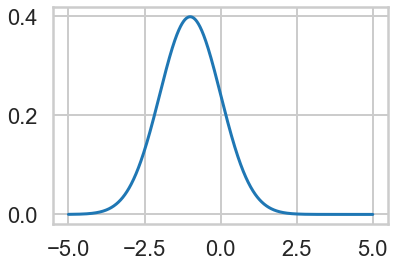

In [11]:
mu,sigma=-1,1
xs=np.linspace(-5,5,1000)
plt.plot(xs, norm.pdf(xs,loc=mu,scale=sigma))

In [12]:
TRAIN_ITERS=10000
M=200 # minibatch size

Let $D$,$G$ be small $3$-layer perceptrons, each with a meager $11$ hidden units in total. $G$ takes as input a single sample of a noise distribution: $z∼unif(0,1)$. We want $G$ to map points $z_1$,$z_2$,...$z_M$ to $x_1$,$x_2$,...$x_M$, in such a way that mapped points $x_i=G(z_i)$ cluster densely where $pdata(X)$ is dense. Thus, $G$ takes in $z$ and generates fake data $x\prime$.
![The distrubution sampler](https://i.imgur.com/fWx86k5.png)
Meanwhile, the discriminator $D$, takes in input $x$ and outputs a likelihood of the input belonging to $p_{data}$.
Let $D_1$ and $D_2$ be copies of $D$, The input to $D_1$ is a single sample of the legitimate data distribution (labelled MNIST in the previous example), $x~p_{data}$, so we want $D_1(x)$ to be maximized while optimizing the decider. $D_2$ will take the fake data from $G$ as its input so we want $D_2(x\prime)$ to be minimized. Hence we have the value function of $D$: $$log(D_1(x))+log(1-D_2(G(z)))$$

In [13]:
# MLP - used for D_pre, D1, D2, G networks
def mlp(input, output_dim):
    # construct learnable parameters within local scope
    w1=tf.get_variable("w0", [input.get_shape()[1], 6], initializer=tf.random_normal_initializer())
    b1=tf.get_variable("b0", [6], initializer=tf.constant_initializer(0.0))
    w2=tf.get_variable("w1", [6, 5], initializer=tf.random_normal_initializer())
    b2=tf.get_variable("b1", [5], initializer=tf.constant_initializer(0.0))
    w3=tf.get_variable("w2", [5,output_dim], initializer=tf.random_normal_initializer())
    b3=tf.get_variable("b2", [output_dim], initializer=tf.constant_initializer(0.0))
    # nn operators
    fc1=tf.nn.tanh(tf.matmul(input,w1)+b1)
    fc2=tf.nn.tanh(tf.matmul(fc1,w2)+b2)
    fc3=tf.nn.tanh(tf.matmul(fc2,w3)+b3)
    return fc3, [w1,b1,w2,b2,w3,b3]

In [14]:
# re-used for optimizing all networks
def momentum_optimizer(loss,var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.001,                # Base learning rate.
        batch,  # Current index into the dataset.
        TRAIN_ITERS // 4,          # Decay step - this decays 4 times throughout training process.
        0.95,                # Decay rate.
        staircase=True)
    #optimizer=tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=batch,var_list=var_list)
    optimizer=tf.train.MomentumOptimizer(learning_rate,0.6).minimize(loss,global_step=batch,var_list=var_list)
    return optimizer

# Pre-train Decision Surface

If decider is reasonably accurate to start, we get much faster convergence.

In [15]:
with tf.variable_scope("D_pre"):
    input_node=tf.placeholder(tf.float32, shape=(M,1))
    train_labels=tf.placeholder(tf.float32,shape=(M,1))
    D,theta=mlp(input_node,1)
    loss=tf.reduce_mean(tf.square(D-train_labels))

In [16]:
optimizer=momentum_optimizer(loss,None)

In [17]:
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

In [18]:
# plot decision surface
def plot_d0(D,input_node):
    f,ax=plt.subplots(1)
    # p_data
    xs=np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')
    # decision boundary
    r=1000 # resolution (number of points)
    xs=np.linspace(-5,5,r)
    ds=np.zeros((r,1)) # decision surface
    # process multiple points in parallel in a minibatch
    for i in range(r//M):
        x=np.reshape(xs[M*i:M*(i+1)],(M,1))
        ds[M*i:M*(i+1)]=sess.run(D,{input_node: x})

    ax.plot(xs, ds, label='decision boundary')
    ax.set_ylim(0,1.1)
    plt.legend()

Text(0.5, 1.0, 'Initial Decision Boundary')

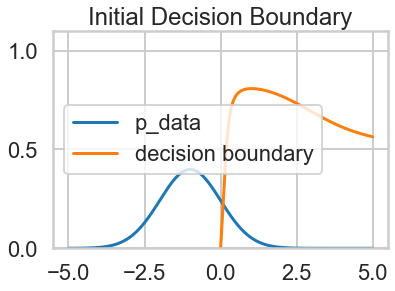

In [19]:
plot_d0(D,input_node)
plt.title('Initial Decision Boundary')
#plt.savefig('fig1.png')

In [20]:
lh=np.zeros(1000)
for i in range(1000):
    #d=np.random.normal(mu,sigma,M)
    d=(np.random.random(M)-0.5) * 10.0 # instead of sampling only from gaussian, want the domain to be covered as uniformly as possible
    labels=norm.pdf(d,loc=mu,scale=sigma)
    lh[i],_=sess.run([loss,optimizer], {input_node: np.reshape(d,(M,1)), train_labels: np.reshape(labels,(M,1))})

Text(0.5, 1.0, 'Training Loss')

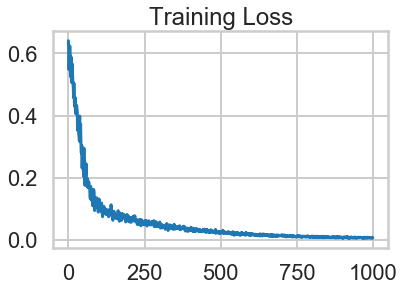

In [21]:
# training loss
plt.plot(lh)
plt.title('Training Loss')

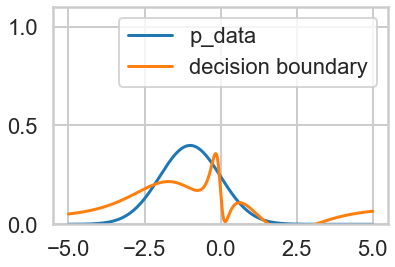

In [22]:
plot_d0(D,input_node)
#plt.savefig('fig2.png')

In [23]:
# copy the learned weights over into a tmp array
weightsD=sess.run(theta)

In [24]:
# close the pre-training session
sess.close()

# Build Net

Now to build the actual generative adversarial network

In [25]:
with tf.variable_scope("G"):
    z_node=tf.placeholder(tf.float32, shape=(M,1)) # M uniform01 floats
    G,theta_g=mlp(z_node,1) # generate normal transformation of Z
    G=tf.multiply(5.0,G) # scale up by 5 to match range
with tf.variable_scope("D") as scope:
    # D(x)
    x_node=tf.placeholder(tf.float32, shape=(M,1)) # input M normally distributed floats
    fc,theta_d=mlp(x_node,1) # output likelihood of being normally distributed
    D1=tf.maximum(tf.minimum(fc,.99), 0.01) # clamp as a probability
    # make a copy of D that uses the same variables, but takes in G as input
    scope.reuse_variables()
    fc,theta_d=mlp(G,1)
    D2=tf.maximum(tf.minimum(fc,.99), 0.01)
obj_d=tf.reduce_mean(tf.log(D1)+tf.log(1-D2))
obj_g=tf.reduce_mean(tf.log(D2))

# set up optimizer for G,D
opt_d=momentum_optimizer(1-obj_d, theta_d)
opt_g=momentum_optimizer(1-obj_g, theta_g) # maximize log(D(G(z)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

In [27]:
# copy weights from pre-training over to new D network
for i,v in enumerate(theta_d):
    sess.run(v.assign(weightsD[i]))

In [28]:
def plot_fig():
    # plots pg, pdata, decision boundary 
    f,ax=plt.subplots(1)
    # p_data
    xs=np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')

    # decision boundary
    r=5000 # resolution (number of points)
    xs=np.linspace(-5,5,r)
    ds=np.zeros((r,1)) # decision surface
    # process multiple points in parallel in same minibatch
    for i in range(r//M):
        x=np.reshape(xs[M*i:M*(i+1)],(M,1))
        ds[M*i:M*(i+1)]=sess.run(D1,{x_node: x})

    ax.plot(xs, ds, label='decision boundary')

    # distribution of inverse-mapped points
    zs=np.linspace(-5,5,r)
    gs=np.zeros((r,1)) # generator function
    for i in range(r//M):
        z=np.reshape(zs[M*i:M*(i+1)],(M,1))
        gs[M*i:M*(i+1)]=sess.run(G,{z_node: z})
    histc, edges = np.histogram(gs, bins = 10)
    ax.plot(np.linspace(-5,5,10), histc/float(r), label='p_g')

    # ylim, legend
    ax.set_ylim(0,1.1)
    plt.legend()

### Inverse Mapping
The inverse transform method converts a sample of $unif(0,1)$ distribution into a sample of any other distribution (as long as the cumulative density function is invertible). There exists some function that maps (a sample from 0-1) to (a sample from the true distribution). Such a function is highly complex and likely has no analytical formula, but a neural network can learn to approximate such a function.

Text(0.5, 1.0, 'Before Training')

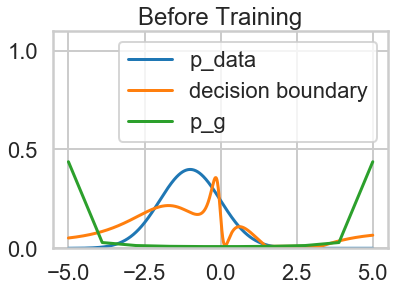

In [29]:
# initial conditions
plot_fig()
plt.title('Before Training')
#plt.savefig('fig3.png')

### Stratified Sampling
Instead of sampling $Z$ via `np.random.random(M).sort()`, we'll use via stratified sampling - we generate M equally spaced points along the domain and then jitter the points randomly. This preserves sorted order and also increases the representativeness the entire training space. We then match our stratified, sorted Z samples to our sorted X samples. The reason is that the mapping arrows should be ordered, else a completely different mapping of $G$ after every minibatch may be obtained, causing the optimizer to fail to converge.
![Before stratification](https://i.imgur.com/Efm3xOr.png)
![After stratification](https://i.imgur.com/Zx4bq1N.png)

In [ ]:
# Algorithm 1 of Goodfellow et al 2014
k=1
histd, histg= np.zeros(TRAIN_ITERS), np.zeros(TRAIN_ITERS)
for i in range(TRAIN_ITERS):
    for j in range(k):
        x= np.random.normal(mu,sigma,M) # sampled m-batch from p_data
        x.sort()
        z= np.linspace(-5.0,5.0,M)+np.random.random(M)*0.01  # sample m-batch from noise prior
        histd[i],_=sess.run([obj_d,opt_d], {x_node: np.reshape(x,(M,1)), z_node: np.reshape(z,(M,1))})
    z= np.linspace(-5.0,5.0,M)+np.random.random(M)*0.01 # sample noise prior
    histg[i],_=sess.run([obj_g,opt_g], {z_node: np.reshape(z,(M,1))}) # update generator
    if i % (TRAIN_ITERS//10) == 0:
        print(float(i)/float(TRAIN_ITERS))

0.0
0.1
0.2
0.3
0.4
0.5


In [ ]:
plt.plot(range(TRAIN_ITERS),histd, label='obj_d')
plt.plot(range(TRAIN_ITERS), 1-histg, label='obj_g')
plt.legend()
#plt.savefig('fig4.png')

In [ ]:
plot_fig()
#plt.savefig('fig5.png')

## Open Questions
For a more detailed analysis with references, refer to [this distill.pub write-up](https://distill.pub/2019/gan-open-problems/).
### Convergence
- This has been proven only for simplified models (LGQ GAN  — linear generator, Gaussian data, and quadratic discriminator ) and with additional assumptions
- Game theory based analysis of these networks allow the convergence to a Nash equilibrium, BUT the resource requirement is generally not useful. i.e., good for a max, but not a min.